# African Antelope Classification using FastAI

Interactive notebook with an end-to-end case study of creating a custom image dataset of major African antelope and training a deep convolutional neural network to classify each species.

The basic workflow is as follows:
1. Download images of each antelope and build a dataset.
2. Pre-process and prepare the dataset for learning.
3. Create a deep neural network model for classification.
4. Train the DNN using transfer learning on the data.
5. Validate and evaluate the model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [3]:
from antelope_classification import *

In [4]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
antelopes = ANTELOPE; print(antelopes)

['kudu', 'eland', 'sable antelope', 'roan antelope', 'waterbuck', 'impala antelope', 'nyala', 'bushbuck', 'tsessebe', 'lichtensteins hartebeest', 'grey duiker', 'steenbok', 'klipspringer']


## Download image data

Download images to data directory, each species is added to its own directory. We also check whether the image file names indicate any potential mislabeling.

In [6]:
download_antelope_images(DATA_PATH)

INFO:root:Directory 'data' is not empty. Skipping image download.


In [7]:
validate_labels(DATA_PATH, ANTELOPE)

INFO:root:Potential mislabeling: data/kudu/39. nyala-kudu-2.jpg
INFO:root:Potential mislabeling: data/kudu/48. nyala-kudu-2.jpg
INFO:root:Potential mislabeling: data/nyala/36. difference-between-kudu-and-nyala-1.jpg


Only *50* examples of each class is downloaded, for a total dataset size of 650 images.

The label validation shows a few potential mislabels, all of which are from species comparison images, and are in fact labeled correctly.

Further manual inspection of the data should be done to ensure there are no other examples that are mislabeled or inappriopate for the task at hand.

## Build and visualize datasets

With the data downloaded, we can construct an [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch) with appropriate transforms. The image data is normalized with the imagenet statistics.

In [8]:
DATA_PATH = Path('data')
VALID_PCT = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [9]:
image_data = ImageDataBunch.from_folder(DATA_PATH, valid_pct=VALID_PCT,\
                                            ds_tfms=get_transforms(), size=IMAGE_SIZE,
                                            bs=BATCH_SIZE).normalize(imagenet_stats)

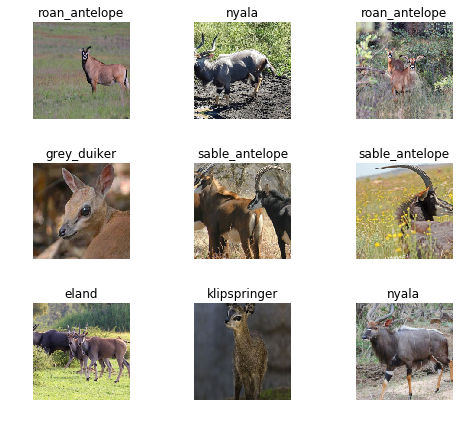

In [10]:
image_data.show_batch(3, figsize=(7,6))

In [11]:
print(image_data.classes)
len(image_data.classes) == image_data.c == len(ANTELOPE)

['bushbuck', 'eland', 'grey_duiker', 'impala_antelope', 'klipspringer', 'kudu', 'lichtensteins_hartebeest', 'nyala', 'roan_antelope', 'sable_antelope', 'steenbok', 'tsessebe', 'waterbuck']


True

We visualize a batch of data to get an idea of what will be passed to the CNN. We also validate that the ImageDataBunch correctly picked all of our classes, which it did.

## Create Pre-trained Model

In [12]:
ARCHITECTURE = models.resnet50

We now create a CNN model pre-trained on the Imagenet dataset.

In [13]:
learn = cnn_learner(image_data, ARCHITECTURE, metrics=[error_rate, accuracy])

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

The model output shows us the exact structure of the CNN we are using (a ResNet50 in this case). We make no further modifications to the model architecture.

## Train Model (top layer)

In the first stage of training, we only fine-tune (train) the top (fully-connected) layers of the ResNet. We first find an appropriate learning rate to use.

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


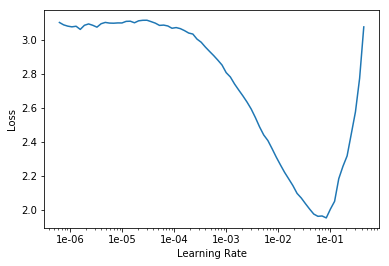

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.444784,0.511338,0.144105,0.855895,00:13
1,0.904843,0.689613,0.213974,0.786026,00:12
2,0.647526,0.553077,0.165939,0.834061,00:12
3,0.478925,0.516207,0.131004,0.868996,00:12
4,0.359557,0.499881,0.148472,0.851528,00:13


In [18]:
learn.save('stage-1')

We train the network for 5 epochs using the learning rate range we found using `lr_find`. The network achieves and accuracy of about 85\% after the initial training.

### Results and Interpretation

With the model trained we can investigate where the model is struggling and validate its accuracy.

In [19]:
from sklearn.metrics import f1_score

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

In [21]:
losses, idxs = interp.top_losses()

In [22]:
len(image_data.valid_ds) == len(losses)

True

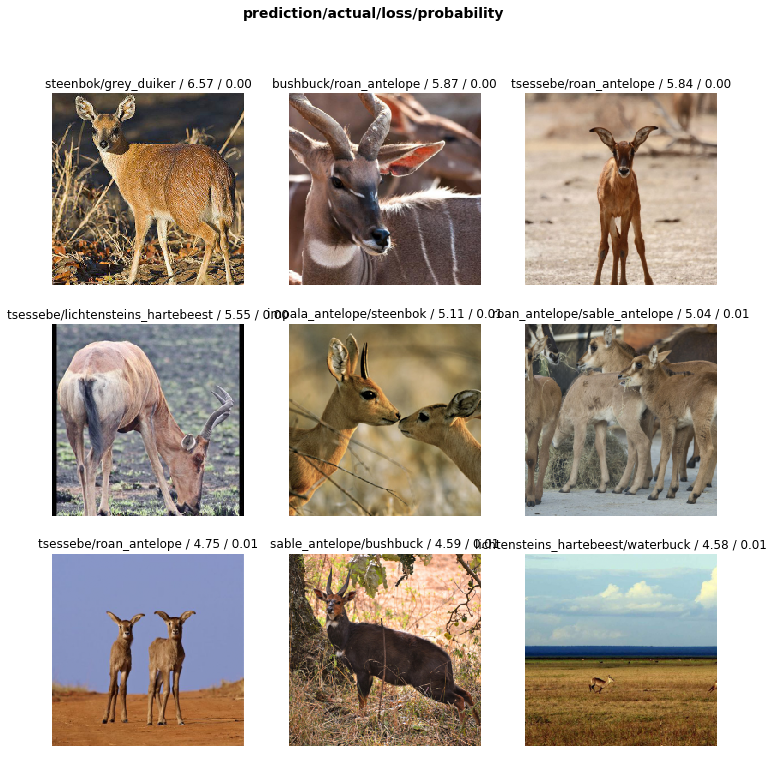

In [23]:
interp.plot_top_losses(9, heatmap=False)

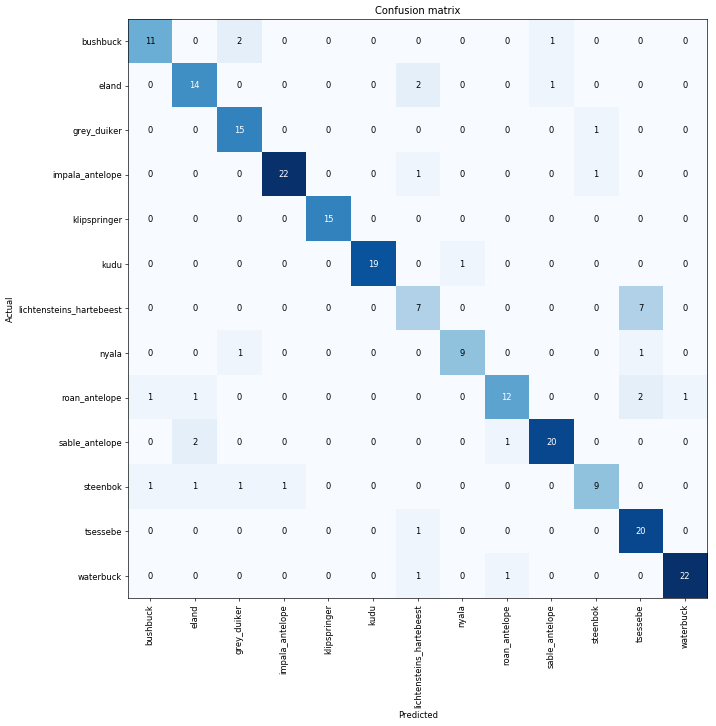

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('lichtensteins_hartebeest', 'tsessebe', 7),
 ('bushbuck', 'grey_duiker', 2),
 ('eland', 'lichtensteins_hartebeest', 2),
 ('roan_antelope', 'tsessebe', 2),
 ('sable_antelope', 'eland', 2)]

In [26]:
preds, targets = learn.TTA()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.8820960698689956

Looking at the images the network is struggling with, there is only one example that looks almost impossible to classify due to the cropping (center image), suggesting there is ample room for improvement. Further, the images that the network is most confused about are of species that are not very similar (e.g. Roan Antelope vs Lichtenstein's Hartebeest).
Still, an F1 score of 0.88 is achieved with test time augmentation.

## Full Model Training

To improve the network's performance, we can proceed with unfreezing the learning, allowing us to train all the layers of the ResNet (instead of just fine tuning the final layers as with stage-1).

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


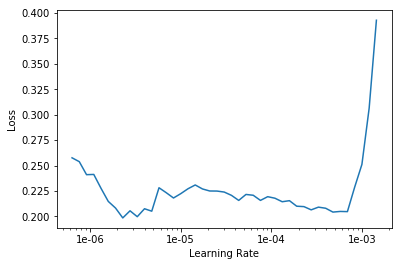

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.231053,0.477937,0.148472,0.851528,00:15
1,0.205780,0.458701,0.131004,0.868996,00:16
2,0.173596,0.418958,0.139738,0.860262,00:16
3,0.150457,0.407409,0.117904,0.882096,00:16
4,0.147088,0.409437,0.122271,0.877729,00:16


In [31]:
learn.save('stage-2')

We train the (entire) network for another 5 epochs, again starting by finding an appropriate learning rate. Unfortunately it doesn't seem the model has improved much, achieving an accuracy of 87\%. The training loss is also significanlty lower than the validation loss, and is still improving, which indicates that the network is overfitting on the training set.

### Results and Interpretation

We again analyze the performance and validate the F1 score.

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

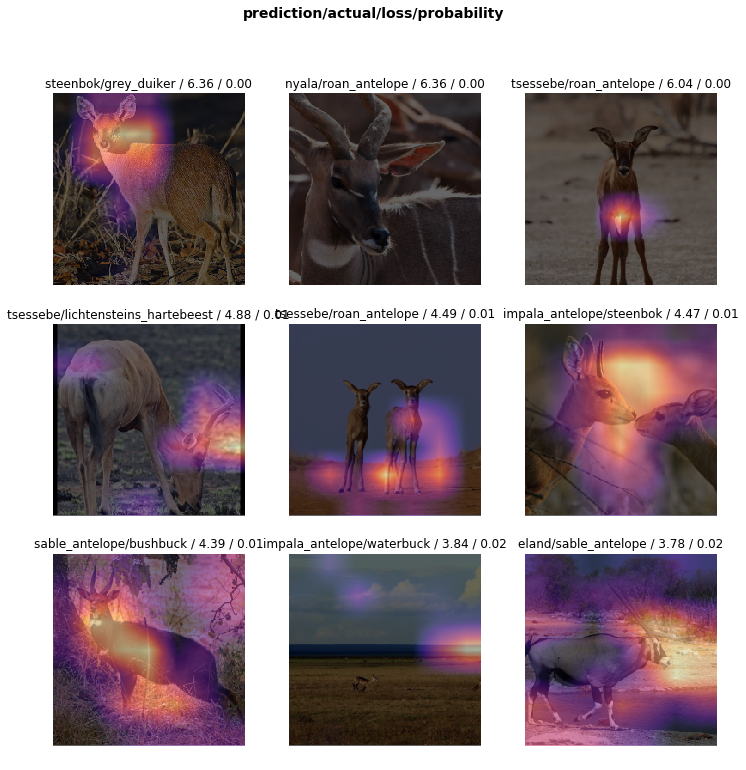

In [33]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=True)

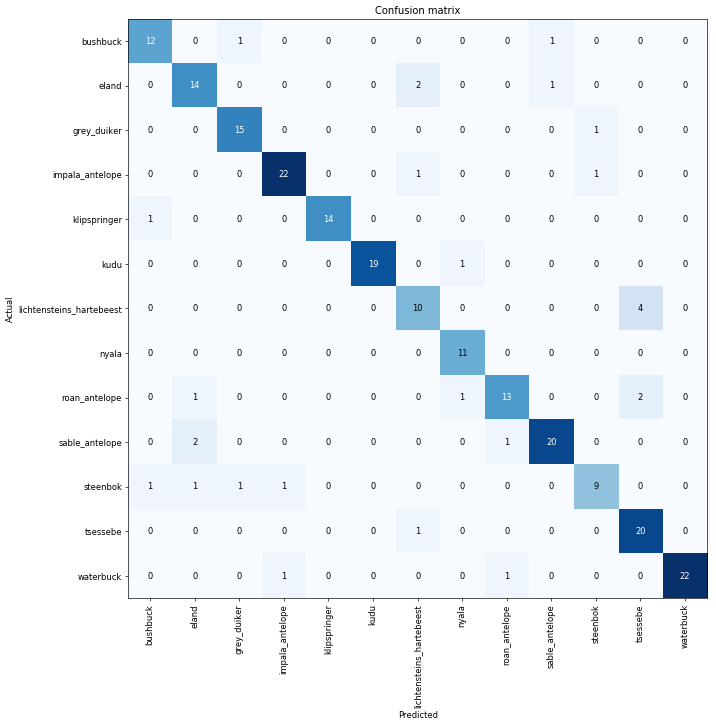

In [34]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [35]:
interp.most_confused(min_val=2)

[('lichtensteins_hartebeest', 'tsessebe', 4),
 ('eland', 'lichtensteins_hartebeest', 2),
 ('roan_antelope', 'tsessebe', 2),
 ('sable_antelope', 'eland', 2)]

Even though the accuracy itself has not greatly improved, the network is more confident in some of the classes. It also now seems to be struggling with species that are similar to each other e.g. Tsessebe vs Lichtenstein's Hartebees.

When looking at the examples with the highest loss, we can note that in two of the examples the view is from the front of the antelope instead of the typical broadside view. More examples of specifically this case should be added to the dataset.

### Final F1 Score with Test Time Augmentation

In [36]:
preds, targets = learn.TTA()
predicted_classes = np.argmax(preds, axis=1)

f1_score(targets, predicted_classes, average='micro')

0.9170305676855895

## Further Improvement

With only 520 training examples (20\% of the dataset was used for validation), 50 per class, the network achieves a final F1 score of 0.917 with TTA after 10 epochs of training. This is pretty good, but I expect it can be improved upon. Potential areas to investigate are:

- Validate the transformations used to augment the dataset (especially rotation and colour).
- Alternative architectures to avoid overitting. Even a smaller ResNet might be more appropriate.
- Gather more data, especially of examples of specific edge cases (such as the frontside view).